# Interpolation of REBCO layer temperature from Critical Current measured during irradiation

Here we plot all the critical temperature vs temperature calibrations used to estimate the temperature of REBCO during irradiation. On each plot, we overlay the "beam off IV" for each of the "beam on events" where we use the calibration as evidence that the calibration has not changed.

In [173]:
%pylab notebook

import warnings
warnings.filterwarnings("ignore")

import sys, os
import importlib
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns

sys.path.append('/Users/alexisdevitre/Documents/code/hts-irradiation')
import hts_fitting as hts, hts_fitfunctions as ff, hts_misc as misc, default_figure_style as dfs
for lib in [hts, ff, misc, dfs]:
    importlib.reload(lib)

    

cols = [0, 1, 12, 13, 14, 19, 23, 25, 27, 29, 41, 52, 53, 54, 55, 56, 57, 58, 59]
names = [
    'tapeid', 
    'anneal',
    'energy', 
    'power', 
    'powerError',
    'ic0',
    'icoff',
    'noff',
    'icon',
    'non',
    'tTAR_OFF',
    'tREBCO',
    'degradation',
    'degradationError',
    'suppression', 
    'suppressionError',
    'suppression_corrected',
    'suppressionError_corrected',
    'outlier' 
]
df = pd.read_excel(dfs.master, sheet_name='data', usecols=cols, names=names, skiprows=1)

#################################
########## Filter data ##########
#################################
cut = df.tTAR_OFF < 20
cut &= (df.suppression != np.nan) & (df.suppression > 0) & (df.suppressionError > 0)
cut &= df.outlier != 1

data = df[cut]

print('\n\nTotal datapoints', data.energy.count())
for tapeid in data.tapeid.unique():
    print('\nDatapoints for', tapeid, data[data.tapeid==tapeid].energy.count())

df.columns

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Total datapoints 689

Datapoints for f33 68

Datapoints for f20 14

Datapoints for f34 9

Datapoints for f29 304

Datapoints for f23 2

Datapoints for f28 69

Datapoints for f37 223


Index(['tapeid', 'anneal', 'energy', 'power', 'powerError', 'ic0', 'icoff',
       'noff', 'icon', 'non', 'tTAR_OFF', 'tREBCO', 'degradation',
       'degradationError', 'suppression', 'suppressionError',
       'suppression_corrected', 'suppressionError_corrected', 'outlier'],
      dtype='object')

## We find an empirical relation between Ic and Tc degradation

It holds suprisingly well for all samples, except ffj20!

<IPython.core.display.Javascript object>


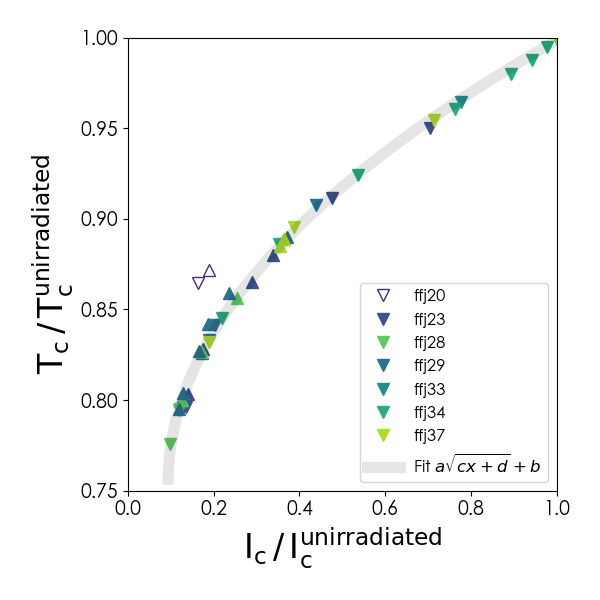

[ 0.69975365  0.75392883  0.13455914 -0.01259732]


In [99]:
fig, ax = plt.subplots()
ax.set_xlabel('$\mathrm{I_c \, / \, I_c^{unirradiated}}$', fontsize=24)
ax.set_ylabel('$\mathrm{T_c \, / \, T_c^{unirradiated}}$', fontsize=24)
ax.set_xlim(0., 1.0)
ax.set_ylim(0.75, 1.0)

df = pd.read_excel(dfs.master, sheet_name='TcIc', usecols=[0, 1, 4, 6], names=['tapeid', 'anneal', 'tc', 'ic'], skiprows=1)

icnorm = []
tcnorm = []

for tapeid in [t for t in np.sort(df.tapeid.unique())]: # if t != 'f20']:
    data = df[df.tapeid == tapeid]
    x, y = data.ic/data.ic.max(), data.tc/data.tc.max()
    
    if tapeid != 'f20':
        for d in x.values:
            icnorm.append(d)
        for d in y.values:
            tcnorm.append(d)
        mec = mfc = dfs.colors_tapes[tapeid]
    else:
        mec, mfc = dfs.colors_tapes[tapeid], 'None'
        
    ax.plot(x[data.anneal == 1], y[data.anneal == 1], marker='v', markersize=8, linestyle='None', mfc=mfc, mec=mec, label=tapeid.replace('f', 'ffj'))
    ax.plot(x[data.anneal > 1], y[data.anneal > 1], marker='^', markersize=8, linestyle='None', mfc=mfc, mec=mec)

fitfunction = ff.sqrt

popt, pcov = curve_fit(fitfunction, icnorm, tcnorm)
xsmooth = np.linspace(0, 1, 10000)
xsmooth = xsmooth[popt[2]*xsmooth >= np.abs(popt[3])]
ysmooth = fitfunction(xsmooth, *popt)
print(popt)

ax.plot(xsmooth, ysmooth, linewidth=8, alpha=.1, color='k', label='Fit $a \sqrt{cx+d}+b$')
ax.legend(loc='lower right', ncols=1)
fig.tight_layout()

ax.set_rasterized(True)
plt.savefig(dfs.outputDirectory+'degradation-b.svg')

## We show that Ic(T) is a monotonic function of degradation

<IPython.core.display.Javascript object>


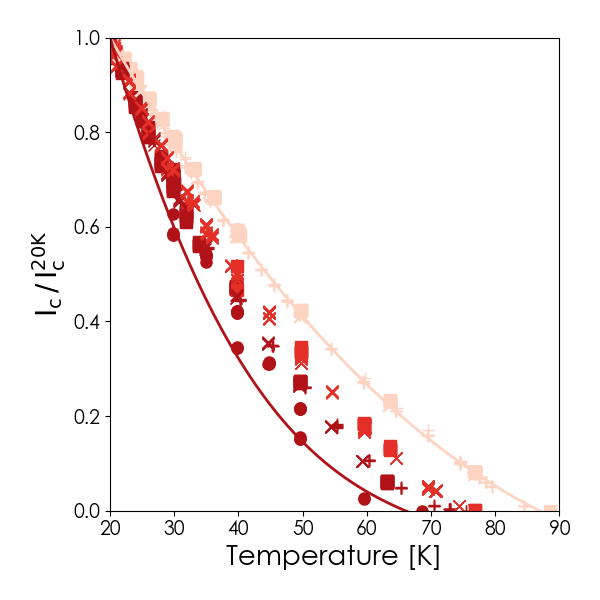

/Users/alexisdevitre/Desktop/IcT/f20/0e20pm2/Ic_2023-10-26_13-55-35929899_f20-pristine-28K.txt Optimal parameters not found: Number of calls to function has reached maxfev = 600.
/Users/alexisdevitre/Desktop/IcT/f28/0e20pm2/Ic_2024-03-08_08-48-17476264_f28-0e0pm2-40k.txt zero-size array to reduction operation maximum which has no identity
/Users/alexisdevitre/Desktop/IcT/f28/6e20pm2/Ic_2024-03-12_18-58-55310893_f28-6e20pm2-1200keV-0nA-30k.txt Optimal parameters not found: Number of calls to function has reached maxfev = 600.
0.09249471677635596
/Users/alexisdevitre/Desktop/IcT/f29/0e20pm2/Ic_2024-02-06_10-02-15263819_f29-pristine-64K.txt Optimal parameters not found: Number of calls to function has reached maxfev = 600.
/Users/alexisdevitre/Desktop/IcT/f29/before800keV/Ic_2024-02-26_14-07-03948994_f29-6e20pm2-anneal300K-40K.txt Optimal parameters not found: Number of calls to function has reached maxfev = 600.
/Users/alexisdevitre/Desktop/IcT/f29/before800keV/Ic_2024-02-26_13-51-455844

In [170]:
fig, ax = plt.subplots()
fitfunction = ff.cubic2
path_top = '/Users/alexisdevitre/Desktop/IcT/'

pristineTemperature = np.array([])
damagedTemperature =  np.array([])
pristineIc = np.array([])
damagedIc = np.array([])

degradation = []
palette = sns.color_palette('Reds', 5)

for tape, m in zip(['f20', 'f28', 'f29', 'f37'], ['+', 'o', 's', 'x']):
    path_tape = path_top+'{}/'.format(tape)
    
    for icT in np.sort([f for f in os.listdir(path_tape) if f != '.DS_Store']):
        if '77' not in icT:
            path = path_tape+'{}/'.format(icT)
            fpaths = [path+f for f in os.listdir(path) if f[:2] == 'Ic']
            _, _, ics, temperatures, _ = hts.getIcT(fpaths, vb=False)
            
            ic20k = np.max(ics)
            if icT == '0e20pm2':
                ic020k = ic20k
                ics.append(0.001)
                temperatures.append(88.5)
                pristineTemperature = np.append(pristineTemperature, temperatures)
                pristineIc = np.append(pristineIc, np.array(ics)/ic20k)
                
                
            if icT == 'afterBeamOn':
                ics.append(0.001)
                temperatures.append(68.62868916)
                damagedTemperature = temperatures
                damagedIc = np.array(ics)/ic20k
                print(ic20k/ic020k)
            x, y = np.array(temperatures), np.array(ics)/ic20k
            
            if ic20k/ic020k <= 1:
                c = palette[0]
                if ic20k/ic020k <= 0.8:
                    c = palette[1]
                    if ic20k/ic020k <= 0.6:
                        c = palette[2]
                        if ic20k/ic020k <= 0.4:
                            c = palette[3]
                            if ic20k/ic020k <= 0.2:
                                c = palette[4]
                                
            ax.plot(x, y, linestyle='None', marker=m, color=c)#(1, 1-ic20k/ic020k, 1-ic20k/ic020k))

ax.set_ylim(0, 1)
ax.set_xlim(20, 90)
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('$\mathrm{I_c \, / \, I_c^{20K}}$')
fig.tight_layout()

# Plot the pristine and heavily degraded datasets, and fit to a third-order polynomial
for l, x, y, c, l in zip(['pristine', 'degraded'], [pristineTemperature, damagedTemperature], [pristineIc, damagedIc], [palette[0], palette[4]], ['Pristine', 'Heavily degraded']):
    popt, pcov = curve_fit(fitfunction, x, y)
    ax.plot(xsmooth, fitfunction(xsmooth, *popt), linestyle='-', linewidth=2, color=c, label=l)
    

## Then we take the extremes

<IPython.core.display.Javascript object>


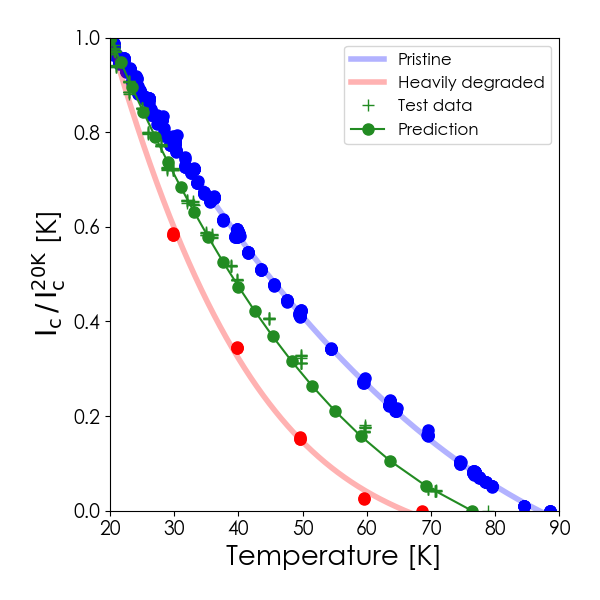

Pristine
Optimized parameters for Pristine [-1.91142195e-07  1.45788152e-04 -2.38487357e-02]


Heavily degraded
Optimized parameters for Heavily degraded [-4.62920679e-06  7.73025030e-04 -4.75032687e-02]




In [164]:
fig, ax = plt.subplots()
fitfunction = ff.cubic2
xsmooth = np.linspace(20, 90, 10000)


# Plot the pristine and heavily degraded datasets, and fit to a third-order polynomial
for l, x, y, c, l in zip(['pristine', 'degraded'], [pristineTemperature, damagedTemperature], [pristineIc, damagedIc], ['b', 'r'], ['Pristine', 'Heavily degraded']):
    popt, pcov = curve_fit(fitfunction, x, y)
    ax.plot(xsmooth, fitfunction(xsmooth, *popt), linestyle='-', linewidth=4, alpha=.3, color=c, label=l)
    ax.plot(x, y, linestyle='None', marker='o', color=c)
    print(l)
    print('Optimized parameters for', l, popt)
    print('\n')
 
# Using the polynomials: try to predict another curve
tape, ic0, interpolation = 'f37', 34.88, '150keV'
path = '/Users/alexisdevitre/Desktop/IcT/{}/{}/'.format(tape, interpolation)
_, _, ic, t, _ = hts.getIcT([path+f for f in os.listdir(path) if (f != '.DS_Store')], vb=False)
icoff = np.max(ic)
ax.plot(t, ic/icoff, marker='+', color='forestgreen', linestyle='None', label='Test data')
yprediction = np.linspace(0, 1, 20)
suppression, icon, xprediction = hts.v_getCorrectedSuppression(yprediction*icoff, icoff, ic0)
ax.plot(xprediction, yprediction, color='forestgreen', marker='o', markersize=8, label='Prediction')


ax.set_ylim(0, 1)
ax.set_xlim(20, 90)
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('$\mathrm{I_c\, /\, I_c^{20K}}$ [K]')
ax.legend()
fig.tight_layout()

## Test with ffj37

<IPython.core.display.Javascript object>


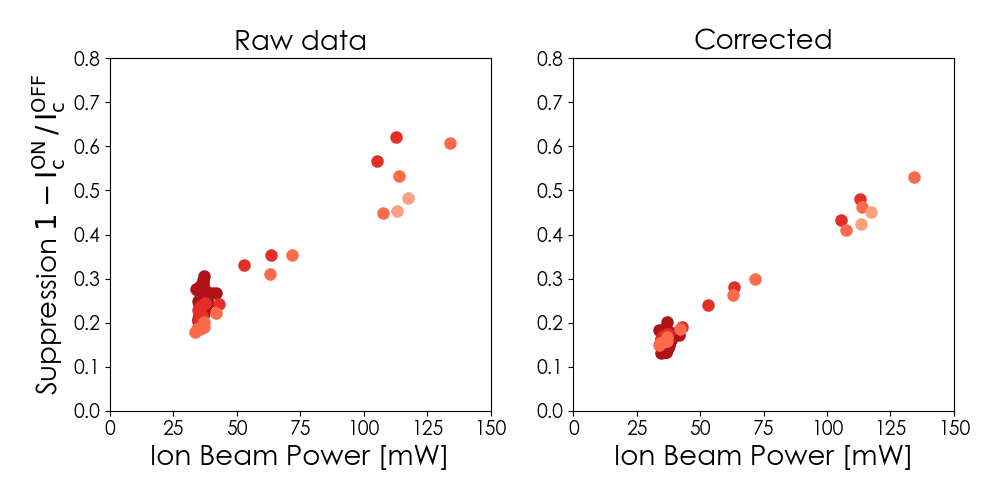

In [197]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

tapeid = 'f37'
  
x, ex = data.power, data.powerError
y, ey = data.suppression_corrected, data.suppressionError
z, ez = data.suppression, data.suppressionError

nsegments = 5
pintervals = np.linspace(0, 1, nsegments)
for p, c in zip(pintervals, sns.color_palette('Reds_r', len(pintervals))):

    cut = (p <= data.degradation) & (data.degradation <= p+1/nsegments) & (data.tapeid == tapeid) & (data.anneal == 1)

    if x[cut].count() > 0:
        axes[1].plot(x[cut], y[cut], marker='o', linestyle='None', color=c, markersize=8, alpha=1)
        axes[0].plot(x[cut], z[cut], marker='o', linestyle='None', color=c, markersize=8, alpha=1)
    
axes[0].set_ylabel('Suppression $\mathrm{1 - I_c^{ON}\, /\, I_c^{OFF}}$')
for ax, t in zip(axes, ['Raw data', 'Corrected']):
    ax.set_ylim(0, .8)
    ax.set_xlim(0, 150)
    ax.set_title(t)
    ax.set_xlabel('Ion Beam Power [mW]')
    #ax.set_ylabel()

fig.tight_layout()

#plt.savefig(outputDirectory+'figure10-powerscaling.svg')    